In [48]:
import numpy as np
import pandas as pd
import gym
from gym import wrappers

import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv

import time
import math
import random

In [ ]:
env = gym.make("FrozenLake-v1", map_name="4x4"  , render_mode = 'human')
env.reset()
x = env.render()

In [11]:
np.random.seed(10)
twenty = generate_random_map(20)
MAPS = {
    "20x20": twenty
}

In [20]:
environment  = 'FrozenLake-v1'
env = gym.make(environment)
size = 4

In [29]:
env.observation_space.n

16

In [34]:
"""
Solving FrozenLake8x8 environment using Value-Itertion.
Author : Moustafa Alzantot (malzantot@ucla.edu)
"""
#https://medium.com/@m.alzantot/deep-reinforcement-learning-demysitifed-episode-2-policy-iteration-value-iteration-and-q-978f9e89ddaa

import numpy as np
import gym
from gym import wrappers


def run_episode(env, policy, gamma = 1.0, render = False):
    """ Evaluates policy by using it to run an episode and finding its
    total reward.
    args:
    env: gym environment.
    policy: the policy to be used.
    gamma: discount factor.
    render: boolean to turn rendering on/off.
    returns:
    total reward: real value of the total reward recieved by agent under policy.
    """
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        if type(obs) != int:
        	action = policy[obs[0]]
        else:
        	action = policy[obs]
        obs, reward, done ,trun , _ = env.step(action)
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward, step_idx


def evaluate_policy(env, policy, gamma = 1.0,  n = 100):
    """ Evaluates a policy by running it n times.
    returns:
    average total reward
    """
    scores = []
    step =[]
    for _ in range(n):
        scores.append(run_episode(env, policy, gamma = gamma, render = False)[0])
        step.append(run_episode(env, policy, gamma = gamma, render = False)[1])
    return np.mean(scores) , np.mean(step)

def extract_policy(v, gamma = 1.0):
    """ Extract the policy given a value-function """
    policy = np.zeros(env.observation_space.n)
    for s in range(env.observation_space.n):
        q_sa = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for next_sr in env.P[s][a]:
                # next_sr is a tuple of (probability, next state, reward, done)
                p, s_, r, _ = next_sr
                q_sa[a] += (p * (r + gamma * v[s_]))
        policy[s] = np.argmax(q_sa)
    return policy


def value_iteration(env, gamma = 1.0 , eps = 1e-10):
    """ Value-iteration algorithm """
    start = time.time()
    v = np.zeros(env.observation_space.n)  # initialize value-function
    max_iterations = 100000
    diff = []
    for i in range(max_iterations):
        prev_v = np.copy(v)
        for s in range(env.observation_space.n):
            q_sa = [sum([p*(r + prev_v[s_]) for p, s_, r, _ in env.P[s][a]]) for a in range(env.action_space.n)] 
            v[s] = max(q_sa)
        if (np.sum(np.fabs(prev_v - v)) <= eps):
            final = i+1
            break
        sum_sq = np.sum(np.square(prev_v - v))
        diff.append(math.sqrt(sum_sq))
    end = time.time()
    return v , diff ,final, end - start 

def compute_policy_v(env, policy, gamma=1.0 ,eps = 1e-10):
    """ Iteratively evaluate the value-function under policy.
    Alternatively, we could formulate a set of linear equations in iterms of v[s] 
    and solve them to find the value function.
    """
    v = np.zeros(env.observation_space.n)

    while True:
        prev_v = np.copy(v)
        for s in range(env.observation_space.n):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, _ in env.P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            # value converged
            break
    return v

def policy_iteration(env, gamma = 1.0):
    """ Policy-Iteration algorithm """
    start= time.time()
    policy = np.random.choice(env.action_space.n, size=(env.observation_space.n))  # initialize a random policy
    max_iterations = 200000

    diff = []
    for i in range(max_iterations):
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(old_policy_v, gamma)
        
        sum_sq = np.sum(np.square(policy - new_policy))
        diff.append(math.sqrt(sum_sq))
        if (np.all(policy == new_policy)):
            final = i+1
            break
        policy = new_policy
    end = time.time()
    return policy , diff ,final, end -start 

def obs_to_state(env, obs):
    """ Maps an observation to state """
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_dx = (env_high - env_low) / n_states
    a = int((obs[0] - env_low[0])/env_dx[0])
    b = int((obs[1] - env_low[1])/env_dx[1])
    return a, b



In [35]:
env_name  = 'FrozenLake-v1'

env = gym.make(env_name)

In [39]:
gamma = [.1, .25, .5 , .75, 1]
eps = [1e-5, 1e-10, 1e-15, 1e-20]
columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average-step'  ]
dataVSmall = pd.DataFrame(0.0, index=np.arange(len(gamma)*len(eps)), columns=columns)
num = 0
diffVSmall =[]
for g in gamma:
    for e in eps:
        optimal_v = value_iteration(env, g);
        policy = extract_policy(optimal_v[0], g)
        policy_score = evaluate_policy(env, policy, g, n=1000)
        dataVSmall['gamma'][num]        = g
        dataVSmall['epsilon'][num]      = e
        dataVSmall['time'][num]         = optimal_v[3]
        dataVSmall['iterations'][num]   = optimal_v[2]
        diffVSmall.append(optimal_v[1])
        dataVSmall['reward'][num]       = policy_score[0]*100
        dataVSmall['average-step'][num] = policy_score[1]
        num +=1

        

In [40]:
print("Value-iteraction for Frozen Lake 4x4")
dataVSmall


Value-iteraction for Frozen Lake 4x4


,gamma,epsilon,time,iterations,reward,average-step
0,0.10,1.000000e-05,0.219012,877.0,0.000003,46.470
1,0.10,1.000000e-10,0.212984,877.0,0.000007,49.693
2,0.10,1.000000e-15,0.228006,877.0,0.000004,48.079
3,0.10,1.000000e-20,0.378998,877.0,0.000002,46.830
4,0.25,1.000000e-05,0.241001,877.0,0.000507,47.608
5,0.25,1.000000e-10,0.213984,877.0,0.000817,50.050
6,0.25,1.000000e-15,0.224017,877.0,0.000438,48.280
7,0.25,1.000000e-20,0.226999,877.0,0.000557,49.881
8,0.50,1.000000e-05,0.231015,877.0,0.024717,50.985
9,0.50,1.000000e-10,0.271013,877.0,0.035124,50.484


In [41]:
gamma = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
eps = [1e-2, 1e-5, 1e-8, 1e-12]
columns = ['gamma',  'time', 'iterations', 'reward','average-step' ]
dataPSmall = pd.DataFrame(0.0, index=np.arange(len(gamma)), columns=columns)
num = 0
diffPSmall =[]
for g in gamma:
    optimal_policy = policy_iteration(env, gamma = g)
    scores = evaluate_policy(env, optimal_policy[0], gamma = g)
    dataPSmall['gamma'][num]        = g
    dataPSmall['time'][num]         = optimal_policy[3]
    dataPSmall['iterations'][num]   = optimal_policy[2]
    diffPSmall.append(optimal_policy[1])
    dataPSmall['reward'][num]       = scores[0]*100
    dataPSmall['average-step'][num] = scores[1]
    num +=1

        

In [42]:
print("Policy-iteraction for Frozen Lake 4x4")
dataPSmall

Policy-iteraction for Frozen Lake 4x4


,gamma,time,iterations,reward,average-step
0,0.1,0.006001,4.0,0.000002,29.71
1,0.2,0.006997,6.0,0.000386,25.33
2,0.3,0.007997,4.0,0.000821,25.18
3,0.4,0.007015,3.0,0.016504,25.33
4,0.5,0.008001,3.0,0.013062,27.91
5,0.6,0.012001,3.0,0.077428,25.91
6,0.7,0.013016,3.0,0.257988,26.70
7,0.8,0.028000,6.0,0.837284,25.86
8,0.9,0.038983,4.0,7.546054,40.83
9,1.0,0.234982,7.0,77.000000,52.76


In [12]:
dataPSmall.groupby(['gamma']).mean()

,time,iterations,reward,average-step
gamma,,,,
0.1,0.005000,3.0,2.420112e-12,30.49
0.2,0.007003,5.0,3.187306e-05,28.59
0.3,0.005998,3.0,3.281777e-03,30.32
0.4,0.008985,4.0,1.438974e-02,29.95
0.5,0.009999,5.0,6.799519e-02,27.60
0.6,0.010999,4.0,1.412719e-01,25.49
0.7,0.016000,4.0,5.887624e-01,25.05
0.8,0.026001,4.0,1.537536e+00,27.89
0.9,0.044999,4.0,5.679862e+00,47.68


<AxesSubplot:title={'center':'PI frozen Lake (score and step vs gamma)'}, xlabel='gamma'>

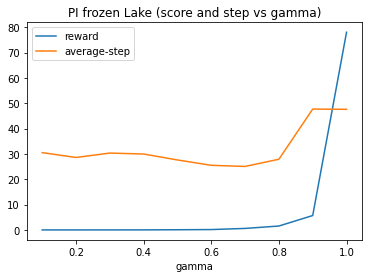

In [16]:
dataPSmall.plot(x = 'gamma', y= ['reward','average-step'] , title = 'PI frozen Lake (score and step vs gamma)')

<AxesSubplot:title={'center':'VI frozen Lake (score and step vs gamma)'}, xlabel='gamma'>

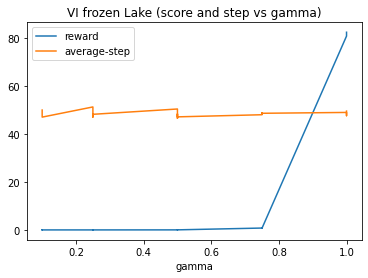

In [17]:
dataVSmall.plot(x = 'gamma', y= ['reward','average-step'] , title = 'VI frozen Lake (score and step vs gamma)')

<AxesSubplot:title={'center':'PI frozen Lake (time vs gamma)'}, xlabel='gamma'>

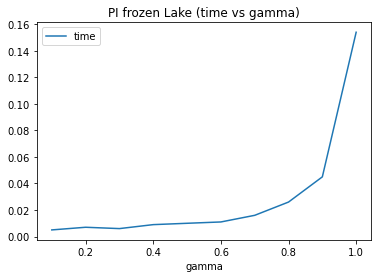

In [19]:
dataPSmall.plot(x = 'gamma', y= ['time'] , title = 'PI frozen Lake (time vs gamma)')

<AxesSubplot:title={'center':'VI frozen Lake (time vs gamma)'}, xlabel='gamma'>

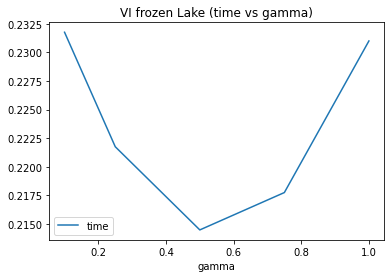

In [27]:
dftime.plot( y= ['time'] , title = 'VI frozen Lake (time vs gamma)')

In [28]:
dftime =dataVSmall.groupby(['epsilon']).mean()

In [29]:
dftime

,gamma,time,iterations,reward,average-step
epsilon,,,,,
1.000000e-20,0.52,0.221799,877.0,16.624558,48.0982
1.000000e-15,0.52,0.220405,877.0,16.639172,48.2382
1.000000e-10,0.52,0.225400,877.0,16.532219,47.9780
1.000000e-05,0.52,0.225792,877.0,16.319146,49.7244


In [43]:
env = gym.make(env_name)

In [44]:
nb_states = env.observation_space.n  # = 16
nb_actions = env.action_space.n      # = 4
qtable = np.zeros((nb_states, nb_actions))

In [68]:
#https://deeplizard.com/learn/video/QK_PP_2KgGE
def ql(total_episodes = 15000,learning_rate = 0.8,max_steps = 99 ,gamma = 0.95 ,epsilon = 1.0,max_epsilon = 1.0, min_epsilon = 0.01, decay_rate = 0.005   ):
    start = time.time()
    rewards = []

    # 2 For life or until learning is stopped
    for episode in range(total_episodes):
        # Reset the environment
        state = env.reset()
        step = 0
        done = False
        total_rewards = 0

        for step in range(max_steps):
            if type(state) != int:
                state = state[0]
            # 3. Choose an action a in the current world state (s)
            ## First we randomize a number
            exp_exp_tradeoff = random.uniform(0, 1)

            ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
            if exp_exp_tradeoff > epsilon:
                action = np.argmax(qtable[state,:])

            # Else doing a random choice --> exploration
            else:
                action = env.action_space.sample()

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done,trun, info = env.step(action)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            # qtable[new_state,:] : all the actions we can take from new state
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])

            total_rewards += reward

            # Our new state is state
            state = new_state

            # If done (if we're dead) : finish episode
            if done == True: 
                break

        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
        rewards.append(total_rewards)

    print ("Score over time: " +  str(sum(rewards)/total_episodes))
    end = time.time()
    return sum(rewards)/total_episodes, end - start

In [71]:
gamma = [ .85 , .9, 1]
decay_rate = [ .01, .05,.1,.5]
res = []
time_ = []
for g in gamma:
    x =[]
    y =[]
    for d in decay_rate:
        run = ql(total_episodes = 15000,learning_rate = 0.8,max_steps = 99 ,gamma = g ,
           epsilon = 1.0,max_epsilon = 1.0, min_epsilon = 0.01, decay_rate = d  )
        x.append(run[0])
        y.append(run[1])
        
    res.append(x)
    time_.append(y)


Score over time: 0.38562
Score over time: 0.3877933333333333
Score over time: 0.38818
Score over time: 0.39048666666666665
Score over time: 0.44078
Score over time: 0.44312
Score over time: 0.44527333333333335
Score over time: 0.4430733333333333
Score over time: 0.015373333333333333
Score over time: 0.015706666666666667
Score over time: 0.01524
Score over time: 0.014486666666666667


In [70]:
res

[[0.29486666666666667,
  0.29973333333333335,
  0.294,
  0.3042666666666667,
  0.2985333333333333],
 [0.3695333333333333, 0.373, 0.3966, 0.379, 0.3962],
 [0.4285333333333333,
  0.42473333333333335,
  0.442,
  0.43706666666666666,
  0.4483333333333333],
 [0.0186, 0.02, 0.0172, 0.0156, 0.0168]]

In [63]:
time_

[3.8699991703033447,
 3.4630141258239746,
 4.184999942779541,
 4.515985012054443,
 5.480014324188232,
 6.2320005893707275,
 7.492999076843262,
 9.010000705718994,
 10.887014150619507,
 29.855000495910645]